# **Install Dependencies**

In [1]:
!pip install ultralytics opencv-python matplotlib segment-anything pillow kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

# **Import Libraries**

In [9]:
import os
import shutil
import glob
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

import torch
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor

import os
import shutil
import zipfile
from google.colab import files # For manual file upload

import yaml

print("--- Libraries Imported ---")

--- Libraries Imported ---


# **Download SAM Checkpoint**

In [3]:
# Create a directory for SAM model
!mkdir -p ./checkpoints
%cd ./checkpoints

# Download the SAM ViT-H model checkpoint (heavy, but most capable)
# Other options: sam_vit_l_0b3195.pth (large), sam_vit_b_01ec64.pth (base)
# Using ViT-B for faster download and less memory usage in Colab for broader compatibility.
# For best results, consider ViT-L or ViT-H if your Colab instance can handle it.
SAM_CHECKPOINT_FILENAME = "sam_vit_b_01ec64.pth"
SAM_MODEL_TYPE = "vit_b"

if not os.path.exists(SAM_CHECKPOINT_FILENAME):
    print(f"Downloading SAM checkpoint: {SAM_CHECKPOINT_FILENAME}...")
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/{SAM_CHECKPOINT_FILENAME}
    print("Download complete.")
else:
    print(f"SAM checkpoint {SAM_CHECKPOINT_FILENAME} already exists.")

%cd ..
print("--- SAM Checkpoint Processed ---")
SAM_CHECKPOINT_PATH = f"./checkpoints/{SAM_CHECKPOINT_FILENAME}"

/content/checkpoints
Download complete.
/content
--- SAM Checkpoint Processed ---


In [4]:
# Cell to explicitly remove old Kaggle credentials
import os
import shutil

kaggle_dir = "/root/.kaggle"
if os.path.exists(kaggle_dir):
    print(f"Removing existing Kaggle directory: {kaggle_dir}")
    shutil.rmtree(kaggle_dir) # This removes the directory and its contents (like kaggle.json)
    print("Old Kaggle directory removed.")
else:
    print("No existing Kaggle directory found at /root/.kaggle.")

# You can also remove the kaggle.json from the current working directory if you uploaded it there previously
# and it wasn't moved, though Cell 4 tries to move it.
if os.path.exists("kaggle.json"):
    print("Removing kaggle.json from current working directory...")
    os.remove("kaggle.json")
    print("kaggle.json removed from current working directory.")

No existing Kaggle directory found at /root/.kaggle.


# **Kaggle API Setup & Dataset Download**



In [5]:
print("Kaggle API Setup & Dataset Download Cell")
print("IMPORTANT: Before running this cell, ensure you have:")
print("1. Accepted the terms for the CORRECTED dataset on the Kaggle website:")
print("   https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection")
print("-" * 30)

kaggle_dir = "/root/.kaggle"
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

if not os.path.exists(kaggle_json_path):
    print(f"'{kaggle_json_path}' not found. Please upload your 'kaggle.json' file.")
    os.makedirs(kaggle_dir, exist_ok=True)
    uploaded = files.upload()
    if "kaggle.json" in uploaded:
        shutil.move("kaggle.json", kaggle_json_path)
        os.chmod(kaggle_json_path, 0o600)
        print(f"kaggle.json uploaded and moved to {kaggle_json_path}")
    else:
        print("ERROR: kaggle.json was not uploaded.")
        raise Exception("Kaggle API key (kaggle.json) not provided or uploaded.")
else:
    print(f"Using existing kaggle.json found at {kaggle_json_path}")

# --- CORRECTED KAGGLE DATASET DETAILS ---
KAGGLE_DATASET_SLUG = "pkdarabi/medical-image-dataset-brain-tumor-detection" # Corrected slug
DATASET_ZIP_NAME = KAGGLE_DATASET_SLUG.split('/')[-1] + ".zip"
# We will determine EXPECTED_DATASET_DIR_NAME after unzipping
# --- END OF CORRECTED KAGGLE DATASET DETAILS ---

DATASET_ROOT_PATH = None
DATA_YAML_PATH = None
download_attempted = False
unzip_attempted = False

if not os.path.exists(DATASET_ZIP_NAME):
    print(f"Attempting to download dataset: {KAGGLE_DATASET_SLUG}...")
    download_command = f"kaggle datasets download -d {KAGGLE_DATASET_SLUG} -p ." # Download only
    print(f"Executing: {download_command}")

    import subprocess
    process = subprocess.Popen(download_command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    exit_code = process.returncode
    download_attempted = True

    if stdout:
        print("Kaggle CLI STDOUT (Download):")
        print(stdout.decode())
    if stderr and exit_code != 0: # Only print stderr if there was an error
        print("Kaggle CLI STDERR (Download):")
        print(stderr.decode())

    if exit_code != 0:
        print(f"ERROR: Kaggle download command failed with exit code {exit_code}.")
        print("This could be due to not accepting dataset terms on Kaggle website (MOST COMMON),")
        print("incorrect API key, dataset slug, or network issues.")
        raise Exception("Kaggle dataset download failed. Check output above.")
    else:
        print(f"Kaggle download command completed successfully. Zip file: {DATASET_ZIP_NAME}")
else:
    print(f"Dataset zip file '{DATASET_ZIP_NAME}' already exists. Skipping download.")

# Unzip the dataset
extracted_dir_name_guess = KAGGLE_DATASET_SLUG.split('/')[-1] # A common extraction name

if not os.path.exists(extracted_dir_name_guess): # Check if already extracted to common name
    if os.path.exists(DATASET_ZIP_NAME):
        print(f"Attempting to unzip '{DATASET_ZIP_NAME}'...")
        try:
            dirs_before_unzip = set(next(os.walk('.'))[1])
            with zipfile.ZipFile(DATASET_ZIP_NAME, 'r') as zip_ref:
                zip_ref.extractall(".")
            print(f"Successfully unzipped '{DATASET_ZIP_NAME}'.")
            unzip_attempted = True

            dirs_after_unzip = set(next(os.walk('.'))[1])
            new_dirs = dirs_after_unzip - dirs_before_unzip

            if len(new_dirs) == 1:
                EXTRACTED_DIR_NAME = new_dirs.pop()
                print(f"Dataset extracted to directory: '{EXTRACTED_DIR_NAME}'")
                DATASET_ROOT_PATH = EXTRACTED_DIR_NAME
            elif len(new_dirs) > 1:
                print(f"WARN: Multiple new directories found: {new_dirs}. Trying to find the best match.")
                slug_part_for_match = KAGGLE_DATASET_SLUG.split('/')[-1].lower().replace('-', ' ')
                found_match = False
                for d in new_dirs:
                    if slug_part_for_match in d.lower().replace('-', ' '):
                        DATASET_ROOT_PATH = d
                        found_match = True
                        print(f"Selected '{d}' as dataset directory based on slug match.")
                        break
                if not found_match:
                     print("Could not auto-determine primary dataset directory from multiple. Check contents.")
                     print(os.listdir("."))
            elif os.path.exists(extracted_dir_name_guess) and os.path.isdir(extracted_dir_name_guess):
                 DATASET_ROOT_PATH = extracted_dir_name_guess # It might have unzipped to the slug name
                 print(f"Dataset seems to be extracted to '{DATASET_ROOT_PATH}'.")
            else:
                print("WARN: No new top-level directory clearly identified. Files might be in current dir or a hidden one.")
                print("Checking current directory for data.yaml or common dataset folders (train, valid, test).")
                if os.path.exists("data.yaml") and (os.path.exists("train") or os.path.exists("images")):
                    DATASET_ROOT_PATH = "."
                    print("Using current directory as dataset root.")
                else:
                    print("Could not determine dataset root directory automatically. Listing contents:")
                    print(os.listdir("."))

        except zipfile.BadZipFile:
            print(f"ERROR: '{DATASET_ZIP_NAME}' is a bad zip file.")
            raise
        except Exception as e:
            print(f"An error occurred during unzipping: {e}")
            raise
    else:
        if download_attempted :
             print(f"ERROR: Dataset zip file '{DATASET_ZIP_NAME}' not found after download attempt.")
else:
    print(f"Presumed extracted dataset folder '{extracted_dir_name_guess}' already exists. Setting it as root.")
    DATASET_ROOT_PATH = extracted_dir_name_guess


# Locate data.yaml
if DATASET_ROOT_PATH and os.path.exists(DATASET_ROOT_PATH):
    yaml_files_found = glob.glob(os.path.join(DATASET_ROOT_PATH, '**', 'data.yaml'), recursive=True)

    if yaml_files_found:
        DATA_YAML_PATH = yaml_files_found[0]
        print(f"--- Data YAML found at: {DATA_YAML_PATH} ---")
        print(f"--- Dataset root considered as: {DATASET_ROOT_PATH} ---")
        print("\nContents of the determined dataset root directory (first few items):")
        for item in os.listdir(DATASET_ROOT_PATH)[:7]:
            print(item)
    else:
        print(f"ERROR: data.yaml not found within '{DATASET_ROOT_PATH}' or its subdirectories.")
        print("Listing contents to help locate data.yaml:")
        for root_dir, dirs, files_in_dir in os.walk(DATASET_ROOT_PATH):
            print(f"In {root_dir}: Dirs: {dirs}, Files: {files_in_dir}")
            # break # Only show top level for brevity
else:
    if unzip_attempted or download_attempted:
        print(f"ERROR: Dataset root directory could not be determined after download/unzip attempt.")
        print("Please check the output and current directory contents:")
        print(os.listdir("."))


if not DATA_YAML_PATH or not os.path.exists(DATA_YAML_PATH):
    print("-" * 50)
    print("CRITICAL ERROR: DATA_YAML_PATH is not correctly configured or data.yaml does not exist.")
    print(f"  Determined DATASET_ROOT_PATH: {DATASET_ROOT_PATH}")
    print(f"  Attempted DATA_YAML_PATH: {DATA_YAML_PATH}")
    print("Please resolve dataset issues. You might need to:")
    print("1. Manually inspect the unzipped folder structure.")
    print("2. Ensure the correct folder is identified as DATASET_ROOT_PATH.")
    print("3. Verify that 'data.yaml' exists and its path is correctly identified for YOLO training.")
    print("-" * 50)
else:
    print("Dataset paths seem correct. Ready to proceed to training.")

Kaggle API Setup & Dataset Download Cell
IMPORTANT: Before running this cell, ensure you have:
1. Accepted the terms for the CORRECTED dataset on the Kaggle website:
   https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection
------------------------------
'/root/.kaggle/kaggle.json' not found. Please upload your 'kaggle.json' file.


Saving kaggle.json to kaggle.json
kaggle.json uploaded and moved to /root/.kaggle/kaggle.json
Attempting to download dataset: pkdarabi/medical-image-dataset-brain-tumor-detection...
Executing: kaggle datasets download -d pkdarabi/medical-image-dataset-brain-tumor-detection -p .
Kaggle CLI STDOUT (Download):
Dataset URL: https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection
License(s): Attribution 4.0 International (CC BY 4.0)


Kaggle download command completed successfully. Zip file: medical-image-dataset-brain-tumor-detection.zip
Attempting to unzip 'medical-image-dataset-brain-tumor-detection.zip'...
Successfully unzipped 'medical-image-dataset-brain-tumor-detection.zip'.
Dataset extracted to directory: 'BrainTumor'
--- Data YAML found at: BrainTumor/BrainTumorYolov11/data.yaml ---
--- Dataset root considered as: BrainTumor ---

Contents of the determined dataset root directory (first few items):
BrainTumorYolov11
BrainTumorYolov9
BrainTumorYolov8
Data

# **Train YOLOv8 Model for Tumor Detection**

In [6]:
YOLO_TRAINED_MODEL_PATH = None # Initialize
if 'DATA_YAML_PATH' in globals() and DATA_YAML_PATH and os.path.exists(DATA_YAML_PATH): # Check if DATA_YAML_PATH is not None and exists
    print(f"--- Starting YOLOv8 Training using data from: {DATA_YAML_PATH} ---")
    yolo_model = YOLO('yolov8n.pt') # Load a pre-trained model (nano version for speed)

    results = yolo_model.train(
        data=DATA_YAML_PATH,
        epochs=30,  # Adjust as needed. Start with 25-50 for reasonable results.
        patience=10,
        imgsz=640,
        project='runs/train',
        name='brain_tumor_yolo_kaggle_v2_exp' # You can give it a new experiment name
    )
    print("--- YOLOv8 Training Completed ---")

    list_of_exp_dirs = glob.glob('runs/train/brain_tumor_yolo_kaggle_v2_exp*')
    if list_of_exp_dirs:
        latest_exp_dir = max(list_of_exp_dirs, key=os.path.getctime)
        YOLO_TRAINED_MODEL_PATH = os.path.join(latest_exp_dir, 'weights/best.pt')
        if os.path.exists(YOLO_TRAINED_MODEL_PATH):
            print(f"Best trained YOLO model saved at: {YOLO_TRAINED_MODEL_PATH}")
        else:
            print(f"ERROR: Trained model 'best.pt' not found in {latest_exp_dir}/weights/. Check training logs.")
            YOLO_TRAINED_MODEL_PATH = None
    else:
        print("ERROR: No experiment directory found. Check training logs.")
        YOLO_TRAINED_MODEL_PATH = None
else:
    print("Skipping YOLO training as DATA_YAML_PATH is not correctly configured or does not exist.")

--- Starting YOLOv8 Training using data from: BrainTumor/BrainTumorYolov11/data.yaml ---


100%|██████████| 6.25M/6.25M [00:00<00:00, 349MB/s]

Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=BrainTumor/BrainTumorYolov11/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_yolo_kaggle_v2_exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=runs/train, rect=Fa

100%|██████████| 755k/755k [00:00<00:00, 51.0MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

  8                  -1  1    460288  ultralytics.nn.modules.block.C2f             [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  1    148224  ultralytics.nn.modules.block.C2f             [384, 128, 1]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 180MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1070.5±376.9 MB/s, size: 31.9 KB)


train: Scanning /content/BrainTumor/BrainTumorYolov11/train/labels... 2144 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2144/2144 [00:01<00:00, 1837.10it/s]

train: New cache created: /content/BrainTumor/BrainTumorYolov11/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2143, len(boxes) = 2144. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 477.6±285.0 MB/s, size: 34.0 KB)


val: Scanning /content/BrainTumor/BrainTumorYolov11/valid/labels... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<00:00, 677.68it/s]


val: New cache created: /content/BrainTumor/BrainTumorYolov11/valid/labels.cache
Plotting labels to runs/train/brain_tumor_yolo_kaggle_v2_exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/train/brain_tumor_yolo_kaggle_v2_exp
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.08G      1.287      3.378      1.363         31        640: 100%|██████████| 134/134 [00:45<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


                   all        612        612      0.451      0.396       0.38      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.57G      1.302      2.355      1.362         24        640: 100%|██████████| 134/134 [00:41<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


                   all        612        612      0.656      0.495      0.493      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.58G      1.338      2.017      1.401         20        640: 100%|██████████| 134/134 [00:40<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


                   all        612        612      0.459      0.545      0.515       0.35

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       2.6G      1.306      1.737      1.372         30        640: 100%|██████████| 134/134 [00:40<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]

                   all        612        612      0.563      0.635      0.634       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.62G       1.26      1.598      1.346         25        640: 100%|██████████| 134/134 [00:40<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.65it/s]


                   all        612        612      0.636      0.589      0.625      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.63G      1.256        1.5      1.338         20        640: 100%|██████████| 134/134 [00:41<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]

                   all        612        612      0.658      0.638      0.708      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.65G      1.227      1.407      1.311         35        640: 100%|██████████| 134/134 [00:41<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.96it/s]

                   all        612        612       0.73      0.655      0.731       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.66G      1.196      1.352      1.294         29        640: 100%|██████████| 134/134 [00:39<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]

                   all        612        612      0.693      0.686      0.726      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.68G      1.175      1.314      1.278         23        640: 100%|██████████| 134/134 [00:40<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]

                   all        612        612      0.737      0.665      0.751      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       2.7G      1.129      1.201      1.258         17        640: 100%|██████████| 134/134 [00:41<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.80it/s]

                   all        612        612      0.752      0.731       0.81      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.71G      1.141      1.182      1.265         30        640: 100%|██████████| 134/134 [00:41<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.79it/s]


                   all        612        612      0.788      0.762       0.81      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.73G      1.112      1.148      1.242         28        640: 100%|██████████| 134/134 [00:40<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]

                   all        612        612      0.781      0.771       0.83      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.75G      1.077      1.134      1.219         28        640: 100%|██████████| 134/134 [00:39<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]

                   all        612        612      0.768      0.747      0.783      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.77G      1.064      1.104      1.217         19        640: 100%|██████████| 134/134 [00:40<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]

                   all        612        612      0.776      0.733      0.796      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.78G      1.071      1.059       1.22         26        640: 100%|██████████| 134/134 [00:40<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]

                   all        612        612      0.767      0.787      0.834      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       2.8G      1.043      1.002      1.203         18        640: 100%|██████████| 134/134 [00:41<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]

                   all        612        612      0.824      0.789      0.857      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.82G      1.014     0.9519      1.182         20        640: 100%|██████████| 134/134 [00:41<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


                   all        612        612      0.823      0.814      0.863      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.83G      1.017      0.954      1.186         24        640: 100%|██████████| 134/134 [00:39<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]

                   all        612        612       0.84       0.81       0.86       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.85G     0.9847     0.9041      1.162         24        640: 100%|██████████| 134/134 [00:42<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.74it/s]

                   all        612        612      0.846      0.825      0.884       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.87G      0.993     0.9043      1.177         30        640: 100%|██████████| 134/134 [00:40<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.68it/s]

                   all        612        612      0.906      0.778      0.893       0.67


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.89G     0.8996     0.7926      1.117         16        640: 100%|██████████| 134/134 [00:40<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]

                   all        612        612      0.851      0.827      0.885      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       2.9G     0.8709     0.7099      1.093         16        640: 100%|██████████| 134/134 [00:39<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.85it/s]


                   all        612        612      0.866      0.826      0.886      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.92G     0.8524     0.6836      1.083         16        640: 100%|██████████| 134/134 [00:38<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]

                   all        612        612      0.882      0.816      0.889      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.94G     0.8261     0.6596      1.064         16        640: 100%|██████████| 134/134 [00:38<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]

                   all        612        612      0.894      0.821      0.897      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.96G     0.8156     0.6343       1.06         16        640: 100%|██████████| 134/134 [00:37<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]

                   all        612        612      0.903      0.809      0.901       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.97G     0.8059     0.6028      1.048         16        640: 100%|██████████| 134/134 [00:37<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]

                   all        612        612      0.907      0.826      0.904      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.99G     0.7775     0.5691      1.038         16        640: 100%|██████████| 134/134 [00:37<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


                   all        612        612      0.884       0.85      0.907      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.01G     0.7695     0.5526       1.03         16        640: 100%|██████████| 134/134 [00:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


                   all        612        612      0.923      0.828      0.918      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.02G     0.7549     0.5384      1.017         16        640: 100%|██████████| 134/134 [00:36<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]

                   all        612        612      0.918      0.844      0.921      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.04G     0.7322     0.5267      1.015         16        640: 100%|██████████| 134/134 [00:37<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]

                   all        612        612      0.897       0.86      0.921      0.709



30 epochs completed in 0.389 hours.
Optimizer stripped from runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/last.pt, 6.2MB
Optimizer stripped from runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/best.pt, 6.2MB

Validating runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/best.pt...
Ultralytics 8.3.153 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


                   all        612        612      0.896      0.859       0.92      0.709
                glioma        285        285      0.838      0.708      0.828      0.559
            meningioma        142        142      0.937      0.945      0.978       0.83
             pituitary        185        185      0.911      0.924      0.953      0.738
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/train/brain_tumor_yolo_kaggle_v2_exp
--- YOLOv8 Training Completed ---
Best trained YOLO model saved at: runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/best.pt


# **Load Trained YOLOv8 Model and Initialize SAM Predictor**

In [7]:
# Load the fine-tuned YOLOv8 model
# YOLO_TRAINED_MODEL_PATH should be like 'runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/best.pt'
if 'YOLO_TRAINED_MODEL_PATH' in globals() and YOLO_TRAINED_MODEL_PATH and os.path.exists(YOLO_TRAINED_MODEL_PATH):
    yolo_detector = YOLO(YOLO_TRAINED_MODEL_PATH)
    print(f"--- Trained YOLOv8 model loaded from {YOLO_TRAINED_MODEL_PATH} ---")
else:
    print("ERROR: No trained YOLO model path found or model doesn't exist.")
    print("Will attempt to use a generic pretrained YOLOv8n model for inference, but this will not be specific to tumors.")
    yolo_detector = YOLO('yolov8n.pt') # Fallback to a generic model

# Setup SAM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} for SAM.")

sam_predictor = None # Initialize to None

# Verify SAM prerequisites are met from Cell 3
sam_checkpoint_defined = 'SAM_CHECKPOINT_PATH' in globals() and SAM_CHECKPOINT_PATH
sam_model_type_defined = 'SAM_MODEL_TYPE' in globals() and SAM_MODEL_TYPE
sam_checkpoint_exists = False
if sam_checkpoint_defined:
    sam_checkpoint_exists = os.path.exists(SAM_CHECKPOINT_PATH)
    print(f"SAM Checkpoint Path (from Cell 3): {SAM_CHECKPOINT_PATH}")
    print(f"SAM Checkpoint Exists: {sam_checkpoint_exists}")
else:
    print("SAM_CHECKPOINT_PATH was not defined in Cell 3.")

if sam_model_type_defined:
    print(f"SAM Model Type (from Cell 3): {SAM_MODEL_TYPE}")
else:
    print("SAM_MODEL_TYPE was not defined in Cell 3.")


if sam_checkpoint_defined and sam_model_type_defined and sam_checkpoint_exists:
    try:
        # Ensure sam_model_registry is available (should have been imported in Cell 2)
        if 'sam_model_registry' not in globals() or 'SamPredictor' not in globals():
            from segment_anything import sam_model_registry, SamPredictor
            print("Re-imported sam_model_registry and SamPredictor in Cell 6 as they were not found in globals.")

        sam = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH)
        sam.to(device=device)
        sam_predictor = SamPredictor(sam)
        print("--- SAM Predictor Initialized Successfully ---")
    except Exception as e:
        print(f"ERROR initializing SAM: {e}")
        print("SAM segmentation might not work.")
else:
    error_msg = "ERROR: SAM setup prerequisites not met. Segmentation with SAM will likely fail."
    if not sam_checkpoint_defined: error_msg += "\n- SAM_CHECKPOINT_PATH is not defined."
    if sam_checkpoint_defined and not sam_checkpoint_exists: error_msg += f"\n- SAM Checkpoint file not found at '{SAM_CHECKPOINT_PATH}'."
    if not sam_model_type_defined: error_msg += "\n- SAM_MODEL_TYPE is not defined."
    print(error_msg)

--- Trained YOLOv8 model loaded from runs/train/brain_tumor_yolo_kaggle_v2_exp/weights/best.pt ---
Using device: cuda for SAM.
SAM Checkpoint Path (from Cell 3): ./checkpoints/sam_vit_b_01ec64.pth
SAM Checkpoint Exists: True
SAM Model Type (from Cell 3): vit_b
--- SAM Predictor Initialized Successfully ---
--- Cell 6 Execution Finished ---


# **Helper Functions for Visualization**

In [8]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6]) # DodgerBlue with alpha
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=150):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax, label="Tumor"):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=2))
    ax.text(x0, y0 - 5, label, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.5, pad=0))

print("--- Helper Functions Defined ---")

--- Helper Functions Defined ---


# **Perform Inference (YOLO Detection + SAM Segmentation) on Sample Images**

Attempting to determine validation image path using DATA_YAML_PATH: BrainTumor/BrainTumorYolov11/data.yaml
Could not resolve val path '../valid/images' relative to 'BrainTumor/BrainTumorYolov11' or 'BrainTumor'.
Fallback: Found validation images at: BrainTumor/BrainTumorYolov11/valid/images
Using validation images from: BrainTumor/BrainTumorYolov11/valid/images

--- Running inference on 3 sample validation images ---
Processing: BrainTumor/BrainTumorYolov11/valid/images/23_jpg.rf.6b18cf59af1ad55c438a4790c1df46c4.jpg

0: 640x640 1 meningioma, 12.4ms
Speed: 3.5ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


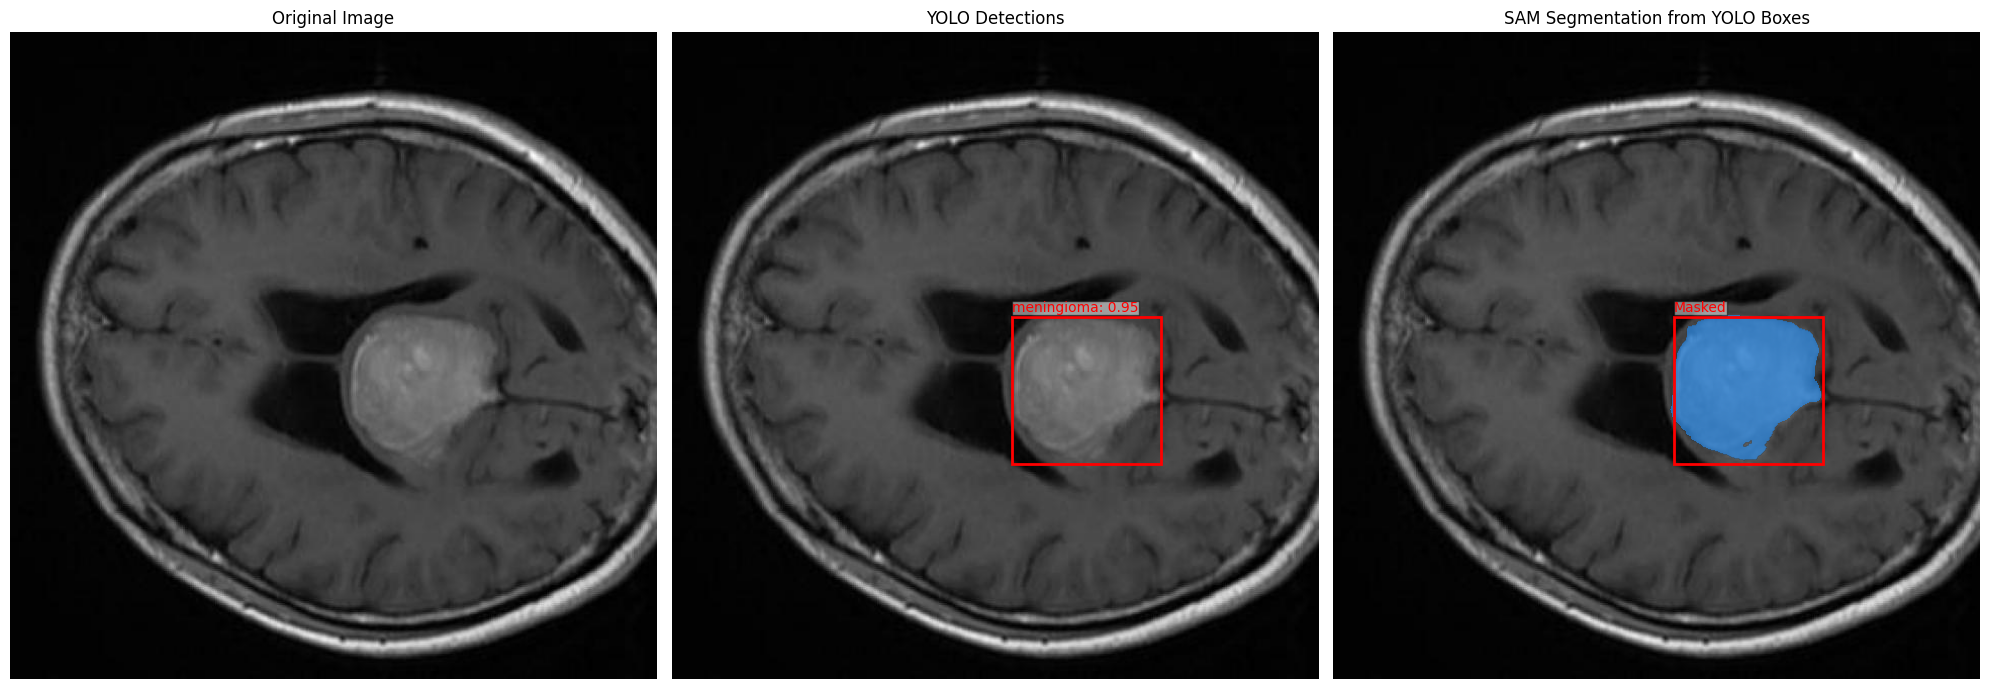

Processing: BrainTumor/BrainTumorYolov11/valid/images/739_jpg.rf.67d2b914d616a7d4344f7e9b0c11aa5b.jpg

0: 640x640 1 glioma, 15.2ms
Speed: 2.9ms preprocess, 15.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


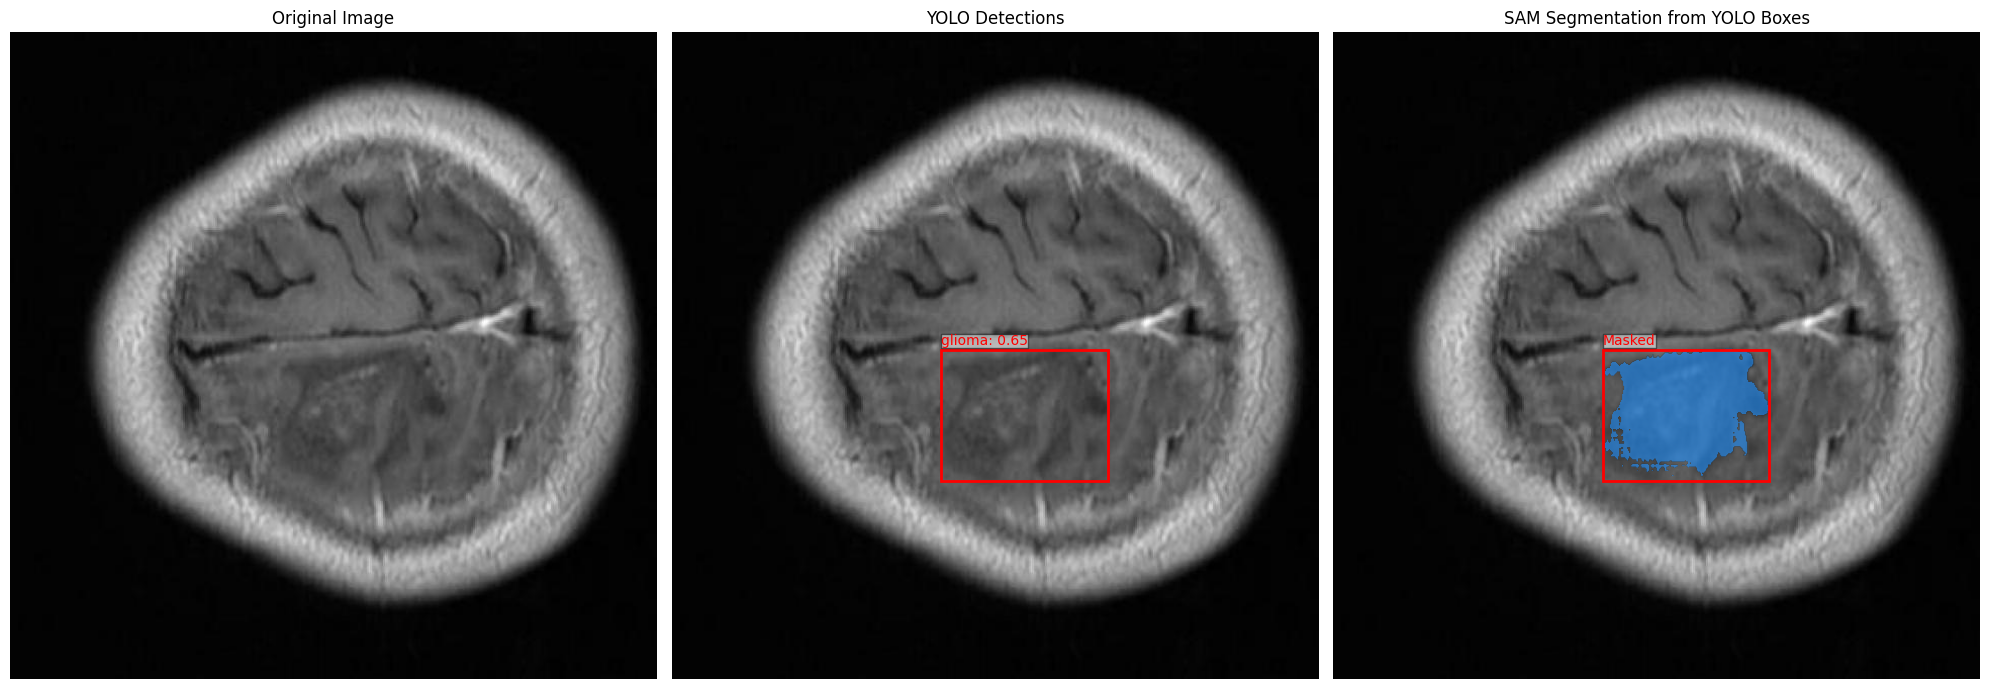

Processing: BrainTumor/BrainTumorYolov11/valid/images/797_jpg.rf.8cef10eacc3ce545282f52983034ef39.jpg

0: 640x640 1 glioma, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


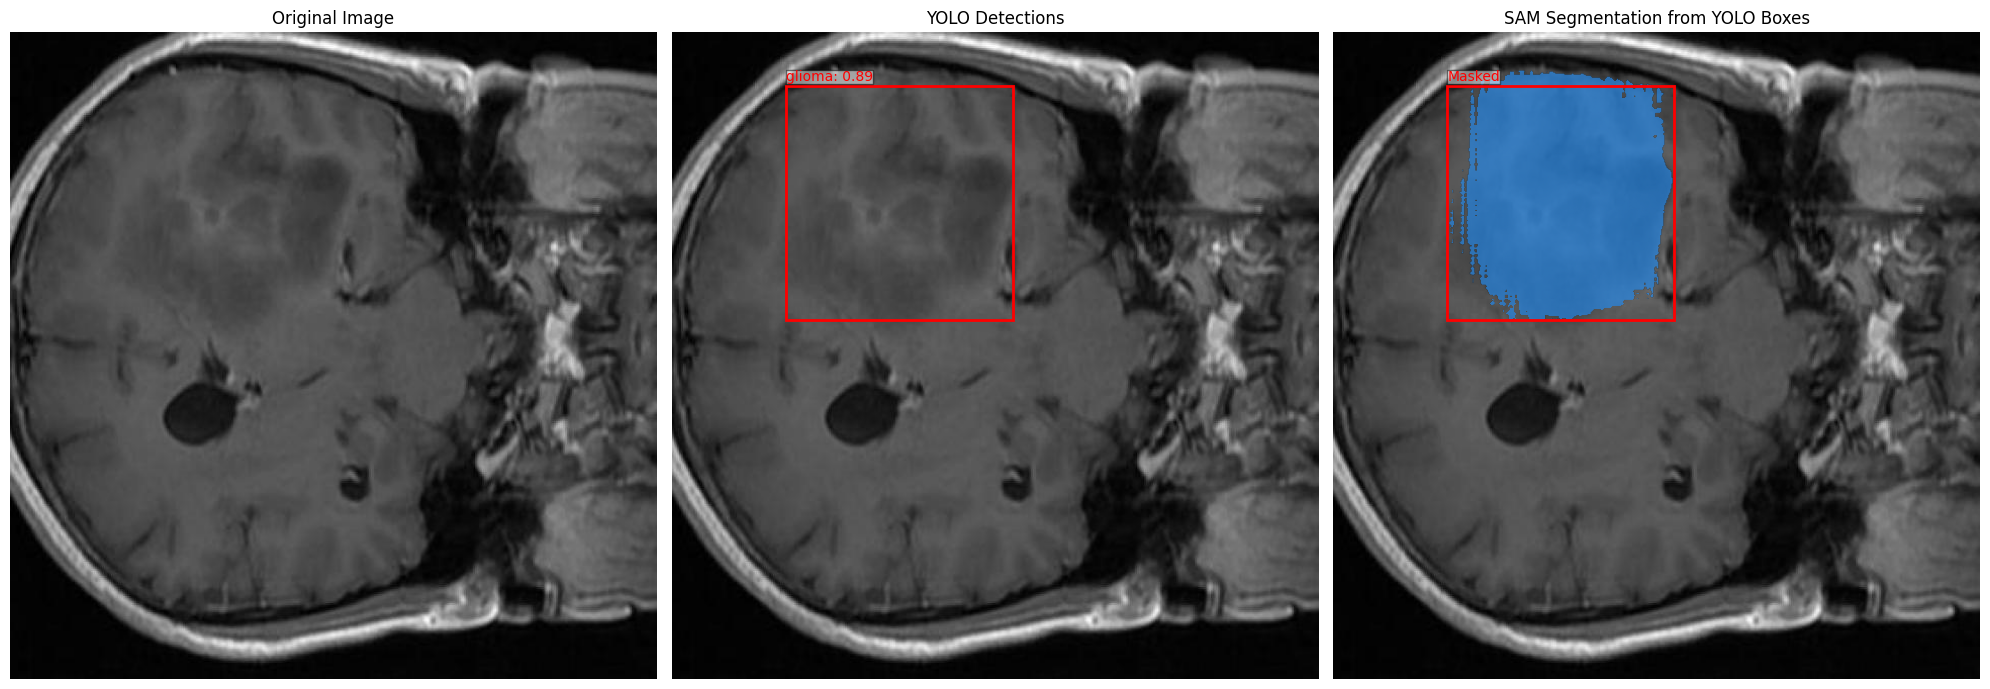


--- End of Inference Cell (Cell 8) ---


In [10]:
def segment_tumors_in_image(image_path, yolo_model, sam_predictor_instance, confidence_threshold=0.25):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return

    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        print(f"Could not read image: {image_path}")
        return
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # 1. YOLO Detection
    yolo_results = yolo_model(image_rgb, conf=confidence_threshold)

    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(image_rgb)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(image_rgb.copy()) # Use a copy for YOLO overlay
    axes[1].set_title("YOLO Detections")
    axes[1].axis('off')

    axes[2].imshow(image_rgb.copy()) # Use a copy for SAM overlay
    axes[2].set_title("SAM Segmentation from YOLO Boxes")
    axes[2].axis('off')

    detected_tumors = 0
    if len(yolo_results) > 0 and yolo_results[0].boxes is not None and len(yolo_results[0].boxes) > 0:
        for result in yolo_results: # Iterate through results (usually one image if one path is passed)
            boxes = result.boxes.xyxy.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            class_ids = result.boxes.cls.cpu().numpy()

            if not hasattr(yolo_model, 'names'):
                class_names_map = {0: "tumor"} # Default if names attribute is missing
            else:
                class_names_map = yolo_model.names

            for i, box in enumerate(boxes):
                if confs[i] >= confidence_threshold:
                    detected_tumors += 1
                    class_id = int(class_ids[i])
                    class_name = class_names_map.get(class_id, f"ClassID_{class_id}")
                    label = f"{class_name}: {confs[i]:.2f}"

                    show_box(box, axes[1], label=label) # Draw YOLO box on the second subplot

                    if sam_predictor_instance:
                        try:
                            sam_predictor_instance.set_image(image_rgb)
                            input_box_sam = box[np.newaxis, :] # SAM expects boxes in (N, 4) format

                            masks, scores, logits = sam_predictor_instance.predict(
                                point_coords=None,
                                point_labels=None,
                                box=input_box_sam,
                                multimask_output=False, # Get only the best mask
                            )

                            if masks.size > 0:
                                show_mask(masks[0], axes[2], random_color=False)
                                show_box(box, axes[2], label=f"Masked") # Show box on SAM plot too
                            else:
                                print(f"SAM did not produce a mask for box: {box}")
                        except Exception as e_sam:
                            print(f"Error during SAM prediction for box {box}: {e_sam}")
                    else:
                        print("SAM predictor not available. Skipping segmentation.")
    else:
        print(f"No detections from YOLO for image {os.path.basename(image_path)} or yolo_results[0].boxes is None.")

    if detected_tumors == 0:
        axes[1].text(0.5, 0.5, "No tumors detected", ha='center', va='center', transform=axes[1].transAxes, fontsize=12, color='red')
        axes[2].text(0.5, 0.5, "No SAM input", ha='center', va='center', transform=axes[2].transAxes, fontsize=12, color='red')

    plt.tight_layout()
    plt.show()

# --- Determine path to validation images ---
val_images_path = None
if 'DATA_YAML_PATH' in globals() and DATA_YAML_PATH and os.path.exists(DATA_YAML_PATH):
    print(f"Attempting to determine validation image path using DATA_YAML_PATH: {DATA_YAML_PATH}")
    try:
        with open(DATA_YAML_PATH, 'r') as f:
            data_config = yaml.safe_load(f)

        # data_yaml_dir is the directory containing the data.yaml file
        # e.g., 'BrainTumor/BrainTumorYolov11'
        data_yaml_dir = os.path.dirname(DATA_YAML_PATH)

        if 'val' in data_config:
            # val_path_in_yaml is the path specified in data.yaml (e.g., 'valid/images' or '../valid/images')
            val_path_in_yaml = data_config['val']

            # Resolve this path. It's usually relative to the project root, which might be
            # the parent of data_yaml_dir if data.yaml is nested.
            # Or, if data.yaml expects paths to be relative to itself, then relative to data_yaml_dir.
            # Ultralytics typically resolves paths relative to the data.yaml's location.

            # Check if val_path_in_yaml is absolute
            if os.path.isabs(val_path_in_yaml):
                val_images_path = val_path_in_yaml
            else:
                # Resolve relative to the directory containing data.yaml
                val_images_path_candidate = os.path.join(data_yaml_dir, val_path_in_yaml)
                if os.path.exists(val_images_path_candidate):
                    val_images_path = val_images_path_candidate
                else:
                    # Some data.yaml files might expect paths to be relative to DATASET_ROOT_PATH
                    # DATASET_ROOT_PATH is 'BrainTumor' in your case
                    if 'DATASET_ROOT_PATH' in globals() and DATASET_ROOT_PATH:
                         val_images_path_candidate_root = os.path.join(DATASET_ROOT_PATH, val_path_in_yaml)
                         if os.path.exists(val_images_path_candidate_root):
                             val_images_path = val_images_path_candidate_root
                         else:
                             print(f"Could not resolve val path '{val_path_in_yaml}' relative to '{data_yaml_dir}' or '{DATASET_ROOT_PATH}'.")
                    else:
                        print(f"Could not resolve relative val path '{val_path_in_yaml}' from '{data_yaml_dir}'. DATASET_ROOT_PATH not available.")

            if val_images_path and not os.path.exists(val_images_path):
                print(f"WARN: Path derived from data.yaml for val images '{val_images_path}' does not exist.")
                val_images_path = None # Reset if path is invalid

        else:
            print("WARN: 'val' key not found in data.yaml. Trying common path structures.")

    except Exception as e:
        print(f"Error parsing data.yaml or constructing validation path: {e}")
        print("Falling back to common path structures.")

    # Fallback or if 'val' key was not helpful
    if not val_images_path:
        yolov11_data_dir = os.path.dirname(DATA_YAML_PATH) # Should be 'BrainTumor/BrainTumorYolov11'
        common_paths_to_check = [
            os.path.join(yolov11_data_dir, "valid", "images"),
            os.path.join(yolov11_data_dir, "validation", "images"),
            os.path.join(yolov11_data_dir, "val", "images"),
            os.path.join(DATASET_ROOT_PATH, "valid", "images"), # Relative to main dataset root
            os.path.join(DATASET_ROOT_PATH, "BrainTumorYolov11", "valid", "images") # Full explicit path
        ]
        for path_check in common_paths_to_check:
            if os.path.exists(path_check):
                val_images_path = path_check
                print(f"Fallback: Found validation images at: {val_images_path}")
                break
else:
    print("DATA_YAML_PATH not configured. Cannot determine validation image path.")


# --- Perform Inference on Sample Images ---
if val_images_path and os.path.exists(val_images_path):
    print(f"Using validation images from: {val_images_path}")
    sample_images_list = [os.path.join(val_images_path, img) for img in os.listdir(val_images_path)]
    sample_images_list = [f for f in sample_images_list if os.path.isfile(f) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if len(sample_images_list) > 0:
        print(f"\n--- Running inference on {min(3, len(sample_images_list))} sample validation images ---")
        if 'yolo_detector' not in globals() or 'sam_predictor' not in globals():
             print("ERROR: yolo_detector or sam_predictor not defined. Make sure Cell 6 (model loading) ran successfully.")
        else:
            if yolo_detector is None or sam_predictor is None:
                print("ERROR: yolo_detector or sam_predictor is None. Model loading in Cell 6 might have failed.")
            else:
                for img_path in random.sample(sample_images_list, min(3, len(sample_images_list))):
                    print(f"Processing: {img_path}")
                    segment_tumors_in_image(img_path, yolo_detector, sam_predictor, confidence_threshold=0.3)
    else:
        print(f"No image files found in the determined validation images directory: {val_images_path}")
else:
    print("Validation images directory could not be determined or does not exist.")
    print("Please verify the dataset structure and that DATA_YAML_PATH is correct.")
    if 'DATASET_ROOT_PATH' in globals(): print(f"DATASET_ROOT_PATH is: {DATASET_ROOT_PATH}")
    if 'DATA_YAML_PATH' in globals(): print(f"DATA_YAML_PATH is: {DATA_YAML_PATH}")

print("\n--- End of Inference Cell (Cell 8) ---")